In [27]:
import numpy as np
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

import pandas as pd
import seaborn as sns

import seaborn as sns
import matplotlib.pyplot as plt
import sys
import tqdm
from tqdm import trange

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu


In [8]:
# Load data
df = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/comparison_bonsai_df.csv')

In [9]:
def calculate_session_proportion(df):
    """
    Calculate session proportion for each subject by dividing current session number 
    by total number of sessions for that subject.
    
    Args:
    df : pd.DataFrame
        DataFrame containing 'subject_id' and 'session' columns
        
    Returns
    pd.DataFrame
        Input DataFrame with new 'session_proportion' column added
    """
    # Get unique subjects
    subjects = df['subject_id'].unique()
    
    # For each subject
    for subject in subjects:
        # Get total sessions for this subject
        subject_df = df[df['subject_id'] == subject]
        total_sessions = len(subject_df)
        
        # Calculate proportion and assign to new column
        mask = df['subject_id'] == subject
        df.loc[mask, 'session_proportion'] = \
            df.loc[mask, 'session'] / total_sessions
        
        # Create classifications based on session proportion for each subject
        subject_proportions = df.loc[mask, 'session_proportion']
        df.loc[mask, 'session_proportion_class'] = pd.cut(
            subject_proportions,
            bins = [float('-inf'), 0.33, 0.66, float('inf')],
            labels = [0, 1, 2]
        )

    return df

df = calculate_session_proportion(df)

df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,abs(logistic_Su2022_bias),abs(logistic_Bari2019_bias),abs(logistic_Hattori2019_bias),abs(logistic_Miller2021_bias),weekday,avg_trial_length_in_seconds,water_day_total_last_session,water_after_session_last_session,session_proportion,session_proportion_class
0,762206,2025-01-12,174459,21.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,0.106583,0.106088,0.098487,0.014647,7,9.622642,NaN,NaN,1.050000,2
1,764691,2025-01-12,174609,20.0,446-6-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,0.337020,0.289721,0.294883,0.176101,7,9.743590,NaN,NaN,1.000000,2
2,762283,2025-01-12,174108,20.0,447-1-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,0.008176,0.012191,0.015373,0.010023,7,10.602911,NaN,NaN,1.000000,2
3,762284,2025-01-12,173828,21.0,446-7-B,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,0.133008,0.127436,0.128040,0.152646,7,8.411215,NaN,NaN,1.000000,2
4,764693,2025-01-12,173719,21.0,446-7-A,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,0.191310,0.110213,0.065721,0.134023,7,8.379888,NaN,NaN,1.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6264,668463,2023-07-10,0,2.0,Tower-1,Lucas Kinsey,NaN,NaN,NaN,Coupled Baiting,...,0.126572,0.125769,0.104619,0.046688,1,7.948417,1.5,0.370,0.076923,0
6265,671087,2023-07-10,0,2.0,Tower-1,Travis Ramirez,NaN,NaN,NaN,Coupled Baiting,...,0.284466,0.264184,0.217023,0.229206,1,8.585209,1.5,0.465,0.062500,0
6266,668463,2023-07-07,1,1.0,Tower-1,Lucas Kinsey,NaN,NaN,NaN,Coupled Baiting,...,0.324793,0.224299,0.141473,0.219687,5,8.725314,1.5,-0.120,0.038462,0
6267,671087,2023-07-06,0,1.0,Tower-1,Travis Ramirez,NaN,NaN,NaN,Coupled Baiting,...,0.001159,0.016022,0.002744,0.001091,4,9.274448,1.5,0.050,0.031250,0


In [10]:
def clean_numeric_features(df, cols, nan_strategy='knn', target_col='session_proportion', min_samples = 2,  knn_neighbors=5, add_indicator=False):
    """
    Clean numeric features by imputing missing values using KNNImputer
    
    Args:
        df: pd.DataFrame
            Input DataFrame
        cols: list
            List of columns to clean
        nan_strategy: str
            Strategy for imputing missing values
        min_samples: int
            Minimum number of samples in each neighborhood for KNNImputer
        knn_neighbors: int
            Number of neighbors to use for KNNImputer
        add_indicator: bool
            If True, add indicator columns for missing values
            
    Returns:
        pd.DataFrame
            DataFrame with cleaned numeric features
    """

    # Create a copy of the dataframe
    df_clean = df.copy()

    # Remove target samples under threshold
    class_counts = df_clean[target_col].value_counts()
    valid_classes = class_counts[class_counts >= min_samples].index
    df_clean = df_clean[df_clean[target_col].isin(valid_classes).copy()]

    new_columns = []

    # Handle infinite values
    for col in cols:
        df_clean.loc[:, col] = df_clean[col].replace([np.inf, -np.inf], np.nan)

    if add_indicator:
        for col in cols:
            if df_clean[col].isna().any():
                indicator_col = f'{col}_is_missing'
                df_clean.loc[:, indicator_col] = df_clean[col].isna().astype(int)
                new_columns.append(indicator_col)

    # drop strat
    if nan_strategy == 'drop':
        df_clean = df_clean.dropna(subset=cols)
    
    # knn strat
    elif nan_strategy == 'knn':
        imputer = KNNImputer(n_neighbors=knn_neighbors)
        df_clean[cols] = imputer.fit_transform(df_clean[cols])

    # median strat
    elif nan_strategy == 'median' or nan_strategy == 'indicator':
        for col in cols:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)

    # Handle extreme values after imputation
    for col in cols:
        Q1 = df_clean[col].quantile(0.01)
        Q3 = df_clean[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
        
    return df_clean, new_columns

In [34]:
feature_cols = [
                'reward_rate', 
                'finished_rate', 
                'double_dipping_rate_finished_trials',
                'foraging_eff',
                'early_lick_rate', 
                'invalid_lick_ratio',
                'lick_consistency_mean_finished_trials',
                'reaction_time_mean'
                ]

cat_cols = ['task']

target_col = 'session_proportion_class'

In [35]:
clean_df, _ = clean_numeric_features(df, 
                                  cols = feature_cols, 
                                  nan_strategy='knn'
                                  )
clean_df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,abs(logistic_Su2022_bias),abs(logistic_Bari2019_bias),abs(logistic_Hattori2019_bias),abs(logistic_Miller2021_bias),weekday,avg_trial_length_in_seconds,water_day_total_last_session,water_after_session_last_session,session_proportion,session_proportion_class
1,764691,2025-01-12,174609,20.0,446-6-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,0.337020,0.289721,0.294883,0.176101,7,9.743590,NaN,NaN,1.000000,2
2,762283,2025-01-12,174108,20.0,447-1-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,0.008176,0.012191,0.015373,0.010023,7,10.602911,NaN,NaN,1.000000,2
3,762284,2025-01-12,173828,21.0,446-7-B,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,0.133008,0.127436,0.128040,0.152646,7,8.411215,NaN,NaN,1.000000,2
4,764693,2025-01-12,173719,21.0,446-7-A,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,0.191310,0.110213,0.065721,0.134023,7,8.379888,NaN,NaN,1.000000,2
5,762206,2025-01-11,163540,20.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,0.135141,0.020979,0.100120,0.019116,6,9.550562,1.0,0.516,1.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6264,668463,2023-07-10,0,2.0,Tower-1,Lucas Kinsey,NaN,NaN,NaN,Coupled Baiting,...,0.126572,0.125769,0.104619,0.046688,1,7.948417,1.5,0.370,0.076923,0
6265,671087,2023-07-10,0,2.0,Tower-1,Travis Ramirez,NaN,NaN,NaN,Coupled Baiting,...,0.284466,0.264184,0.217023,0.229206,1,8.585209,1.5,0.465,0.062500,0
6266,668463,2023-07-07,1,1.0,Tower-1,Lucas Kinsey,NaN,NaN,NaN,Coupled Baiting,...,0.324793,0.224299,0.141473,0.219687,5,8.725314,1.5,-0.120,0.038462,0
6267,671087,2023-07-06,0,1.0,Tower-1,Travis Ramirez,NaN,NaN,NaN,Coupled Baiting,...,0.001159,0.016022,0.002744,0.001091,4,9.274448,1.5,0.050,0.031250,0


In [36]:
def compute_cca(df, feature_cols, target_col):
    """
    For each feature, compute CCA with target column then create new columns
    with canonical variables, weights, and loadings. 

    Args:
        df: pd.DataFrame
            Input DataFrame
        feature_cols: list
            List of feature columns to compute CCA for
        target_col: str
            Target column to compute CCA with

    Returns:
        pd.DataFrame
            DataFrame with new columns for canonical variables, weights, and loadings
    """

    # Create copy
    df_clean = df.copy()

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(df_clean[feature_cols])

    # Reshape to 2D array
    y = df_clean[target_col].values.reshape(-1, 1)

    # Initialize CCA
    cca = CCA(n_components=1)

    # Fit CCA
    X_can, y_can = cca.fit_transform(X, y)

    # Store canonical variables
    df_clean['canonical_X'] = X_can
    df_clean['canonical_y'] = y_can

    # Get feature loadings
    loadings = np.corrcoef(X.T, X_can.T)[:len(feature_cols), -1]
    for feature, loading in zip(feature_cols, loadings):
        df_clean[f'{feature}_loading'] = loading

    return df_clean, cca.score(X, y)
    

In [37]:
df_cca, cca_score = compute_cca(clean_df, feature_cols, target_col)

In [38]:


def plot_cca_results(df, feature_cols, cca_score):

    fig = plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.scatter(df['canonical_X'], df['canonical_y'], alpha=0.5)
    plt.xlabel('Canonical Variable X')
    plt.ylabel('Canonical Variable Y')
    plt.title(f'Canonical Correlation\nScore: {cca_score:.3f}')
    
    loadings = []
    for feature in feature_cols:
        loading = df[f'{feature}_loading'].iloc[0]  # All rows have same loading
        loadings.append((feature, loading))
    

    loadings_df = pd.DataFrame(loadings, columns=['Feature', 'Loading'])
    loadings_df = loadings_df.sort_values('Loading', key=abs, ascending=True)
    
    plt.subplot(2, 2, 2)
    plt.barh(y=np.arange(len(loadings_df)), width=loadings_df['Loading'])
    plt.yticks(np.arange(len(loadings_df)), loadings_df['Feature'])
    plt.xlabel('Loading Value')
    plt.title('Feature Loadings')

    plt.subplot(2, 2, 3)
    sns.kdeplot(data=df['canonical_X'], label='Canonical X')
    sns.kdeplot(data=df['canonical_y'], label='Canonical Y')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution of Canonical Variables')
    plt.legend()
    

    top_features = loadings_df.tail(3)['Feature'].values
    
    plt.subplot(2, 2, 4)
    for feature in top_features:
        sns.kdeplot(data=df[feature], label=feature)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution of Top Features')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

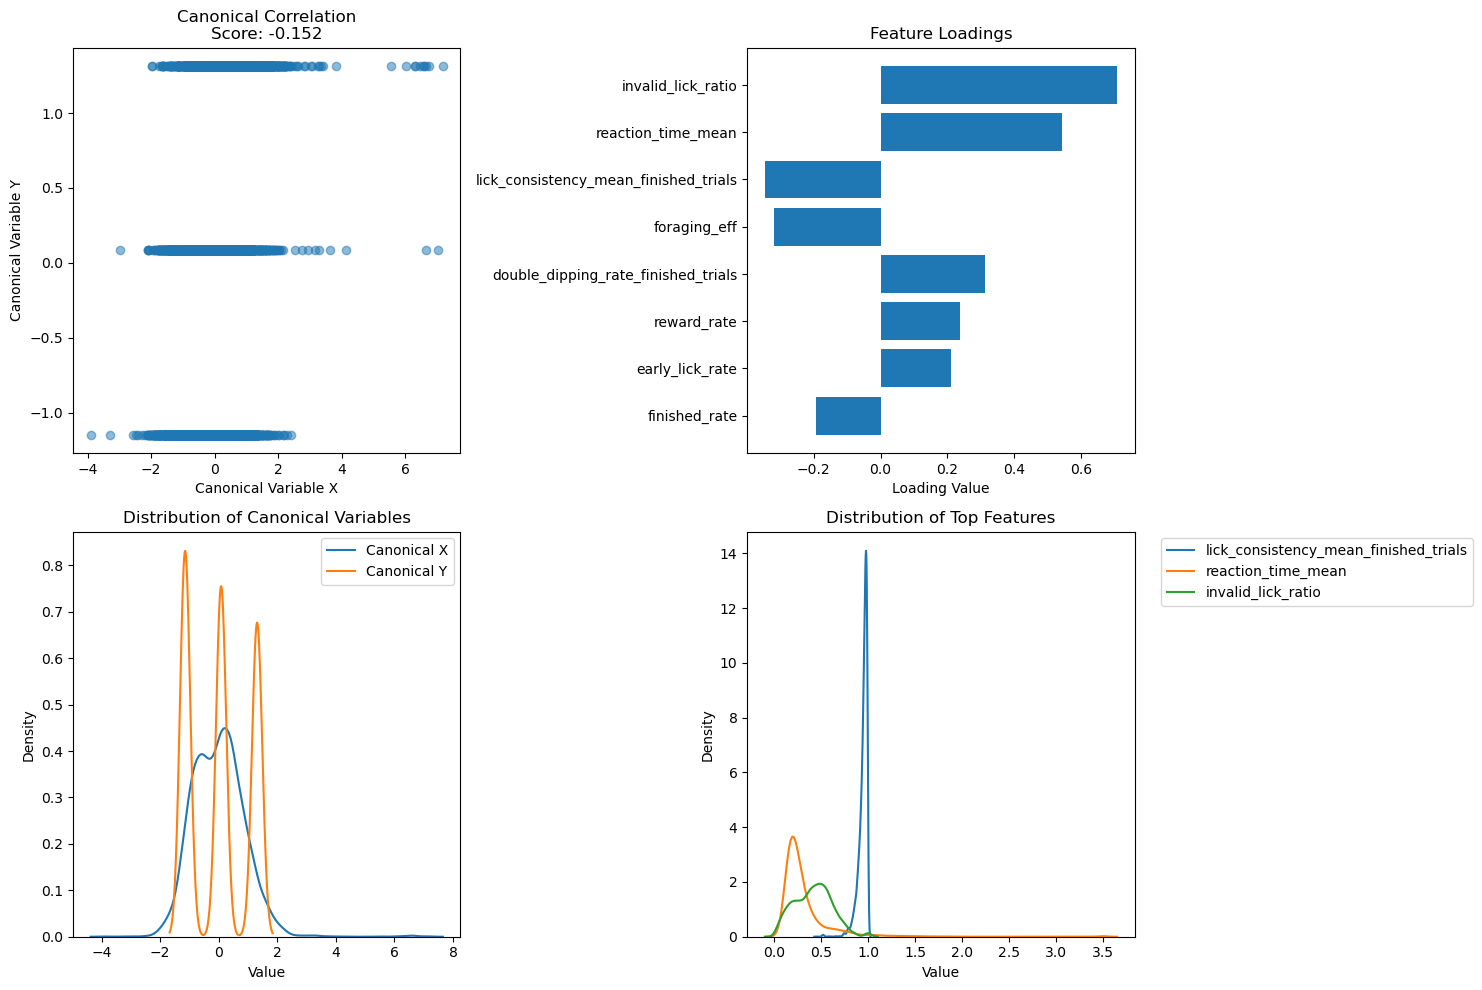

In [39]:
plot_cca_results(df_cca, feature_cols, cca_score)